# CNN Model - Acanthosis Nigricans

In [1]:
# Imports
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
import os
from datetime import datetime
from packaging import version
from PIL import Image
from sklearn.preprocessing import LabelBinarizer

### Hyperparameters

In [2]:
# Parameters
image_size = 128
batch_size = 2
val_size = 0.10
test_size = 0.10

### Preprocessing Pipeline

In [3]:
images = []
folder = os.path.join("Data")
img_widths = []
img_heights = []
total_images = 0
size = {}
for sub_folder in os.listdir(folder):
    if sub_folder == ".DS_Store":
        continue
    sub_path = os.path.join(folder, sub_folder)
    sub_folder_images = 0
    for filename in os.listdir(sub_path):
        if filename == '.DS_Store':
            continue
        img = Image.open(os.path.join(sub_path, filename))
        if img is not None:
            sub_folder_images += 1
            width, height = img.size
            if width not in img_widths:
                img_widths.append(width)
            if height not in img_heights:
                img_heights.append(height)
        else:
            print("Presence of None Images")
    size[sub_folder] = sub_folder_images
    print(f"{sub_folder} image count: {sub_folder_images}")
    total_images += sub_folder_images

print(f"We have a total of {total_images} in our dataset\n")
print(size)
# print(f"Our dataset contains images with the following widths: {img_widths}")
# print(f"Our dataset contains images with the following heights: {img_heights}")
        
# minimum_width = min(img_widths)
# minimum_height = min(img_heights)

# print(f"The minimum width is {minimum_width}")
# print(f"The minimum height is {minimum_height}")

acanthosis_nigricans_negative image count: 53
diabetic_foot_positive image count: 41
acanthosis_nigricans_positive image count: 96
diabetic_foot_negative image count: 34
We have a total of 224 in our dataset

{'acanthosis_nigricans_negative': 53, 'diabetic_foot_positive': 41, 'acanthosis_nigricans_positive': 96, 'diabetic_foot_negative': 34}


In [4]:
# Preprocessing Function
def preprocess(filename, label, encoder, width = image_size, height = image_size):
    #Retrieve image
    image_string = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(image_string, channels=3) #channels set to 1 as it is greyscale
    #Normalise the pixel values from 0-255 to 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    #Resize the image
    img = tf.image.resize(img, [height, width])
    #Encode the label
    encoded_label = encoder.transform([label])[0]
    return img, encoded_label

# Merge Dataset
def merge_dataset(dataset_list):
    for i in range(len(dataset_list)):
        if i == 0:
            merged_dataset = dataset_list[i]
        else:
            merged_dataset = merged_dataset.concatenate(dataset_list[i])
    return merged_dataset

# Split Dataset
def split_dataset(img_datasets, dataset_sizes,  val_size = 0.10, test_size = 0.10):
    #Obtain the training size
    train_size = 1 - val_size - test_size #test_size + train_size + val_size = 1
    
    #Python list to store the tf.dataset from the different classes
    full_train_list = []
    full_val_list = []
    full_test_list = []
    
    for img_dataset, dataset_size in zip(img_datasets, dataset_sizes):
        train_numbers = int(train_size * dataset_size)
        test_numbers = int(test_size * dataset_size)
        val_numbers = int(val_size * dataset_size)
        
        #shuffle the dataset and split it to the respective set
        img_dataset = img_dataset.shuffle(dataset_size, reshuffle_each_iteration=False)
        train_dataset = img_dataset.take(train_numbers)
        val_test_dataset = img_dataset.skip(train_numbers)
        val_dataset = val_test_dataset.take(val_numbers)
        test_dataset = val_test_dataset.skip(val_numbers)
        
        #Append the class train/val/test dataset to the list
        full_train_list.append(train_dataset) 
        full_val_list.append(val_dataset)
        full_test_list.append(test_dataset)
    
    #Merge all the classes' dataset in the list into one single dataset for train/val/test
    train_dataset = merge_dataset(full_train_list)
    val_dataset = merge_dataset(full_val_list)
    test_dataset = merge_dataset(full_test_list)
    
    #Shuffle the Datasets
    train_dataset = train_dataset.shuffle(10000)
    val_dataset = val_dataset.shuffle(10000)
    test_dataset = test_dataset.shuffle(10000)
    
    return train_dataset, val_dataset, test_dataset

In [5]:
#Encoder 
encoder = LabelBinarizer()
y_data_values = np.array(['AN-POSITIVE', 'AN-NEGATIVE'])
encoded = encoder.fit_transform(y_data_values)
print(encoded)

[[1]
 [0]]


In [6]:
#Store the image filenames into a tf.dataset
an_positive_dataset = tf.data.Dataset.list_files("Data/acanthosis_nigricans_positive/*.jpeg", shuffle = False)
an_negative_dataset = tf.data.Dataset.list_files("Data/acanthosis_nigricans_negative/*.jpeg", shuffle = False)

#map the dataset to the preprocessing function
pf = partial(preprocess, label = "AN-POSITIVE", encoder = encoder)
an_positive_image_dataset = an_positive_dataset.map(pf)

pf = partial(preprocess, label = "AN-NEGATIVE", encoder = encoder)
an_negative_image_dataset = an_negative_dataset.map(pf)

#Index of img_dataset must correspond to the index of the dataset_sizes
img_datasets = [an_positive_image_dataset, an_negative_image_dataset]
dataset_sizes = [size["acanthosis_nigricans_positive"], size["acanthosis_nigricans_negative"]]
# #Split the dataset into train/val/test
train_dataset, val_dataset, test_dataset = split_dataset(img_datasets, dataset_sizes,
                                                        val_size = val_size, test_size = test_size)

# #Batch and preload the datasets
train_dataset = train_dataset.batch(batch_size)
# train_dataset = train_dataset.prefetch(1)

test_dataset = test_dataset.batch(batch_size)
# test_dataset = test_dataset.prefetch(1)

val_dataset = val_dataset.batch(batch_size)
# val_dataset = val_dataset.prefetch(1)

/Users/mongchanghsi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


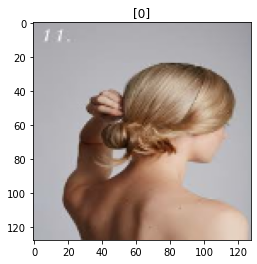

In [7]:
# Display a single image
def displayImage(image, label):
    plt.figure()
    plt.title(label.numpy())
    plt.imshow(image)

# Display Image before Batch
# for image, label in an_positive_image_dataset.take(3):
#     displayImage(image, label)

# Display Image after Batch
for image, label in train_dataset.take(1):
    for i in range(1):
        displayImage(image[i], label[i])

In [8]:
# Optimize dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Base Model

In [9]:
# Base Model
model_input = tf.keras.Input(shape=(image_size, image_size, 3), batch_size=batch_size, dtype='float32', name='input')
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(model_input)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
model_output = tf.keras.layers.Dense(2, name='output')(x)
model = tf.keras.Model(inputs=[model_input], outputs=[model_output])

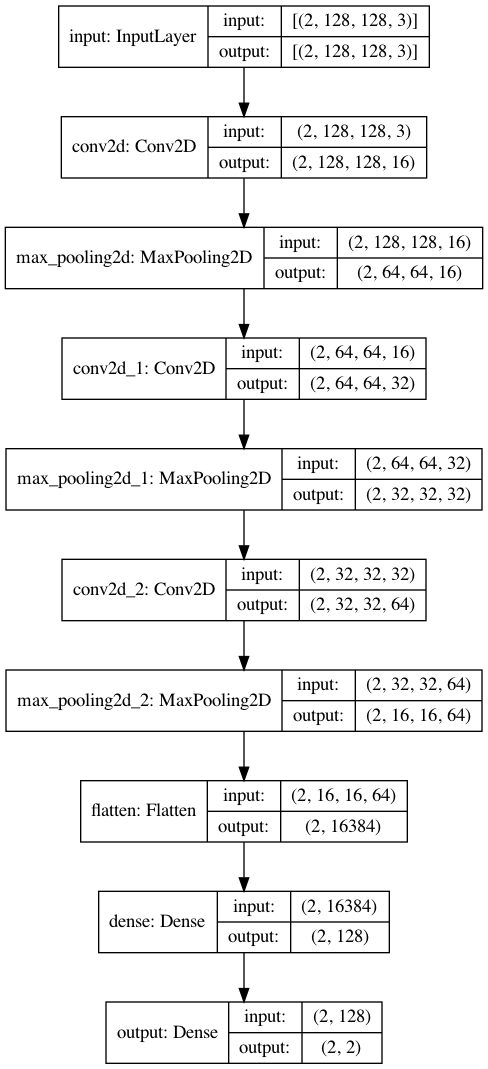

In [10]:
# Print model
dot_img_file = '/Users/mongchanghsi/Desktop/SUTD/Thesis/code/cnn_model/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, expand_nested=True,show_shapes=True)

In [11]:
# Define Loss function and Optimiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [12]:
print(f'''
Model Summary
{'-' * 40}
''')
model.summary()


Model Summary
----------------------------------------

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(2, 128, 128, 3)]        0         
_________________________________________________________________
conv2d (Conv2D)              (2, 128, 128, 16)         448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (2, 64, 64, 16)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (2, 64, 64, 32)           4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (2, 32, 32, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (2, 32, 32, 64)           18496     
_________________________________________________________________
max_

### Training the model

In [13]:
# Train model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
)

Epoch 1/10
59/59 [==============================] - 3s 40ms/step - loss: 8.3875 - accuracy: 0.3790 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 2/10
59/59 [==============================] - 1s 25ms/step - loss: 8.3754 - accuracy: 0.4570 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 3/10
59/59 [==============================] - 1s 23ms/step - loss: 8.3754 - accuracy: 0.4570 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 4/10
59/59 [==============================] - 1s 23ms/step - loss: 8.3754 - accuracy: 0.4570 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 5/10
59/59 [==============================] - 1s 24ms/step - loss: 8.3754 - accuracy: 0.4570 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 6/10
59/59 [==============================] - 1s 24ms/step - loss: 8.3754 - accuracy: 0.4570 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 7/10
59/59 [==============================] - 1s 25ms/step - loss: 8.3754 - accuracy: 0.4570 - val_loss: 9.9160 - val_accuracy: 0.3571
Epoch 8/10
59

In [14]:
# Test the model
results = model.evaluate(test_dataset)

9/9 [==============================] - 0s 4ms/step - loss: 9.5272 - accuracy: 0.3333


## Test

### Preprocessing Function for the Test

In [15]:
def preprocess_actual_run(filename, width = image_size, height = image_size):
    #Retrieve image
    image_string = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(image_string, channels=3) #channels set to 1 as it is greyscale
    #Normalise the pixel values from 0-255 to 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    #Resize the image
    img = tf.image.resize(img, [height, width])
    return img

### Prediction using Positive Image

In [16]:
positive_test_image = tf.data.Dataset.list_files("Data/acanthosis_nigricans_positive/acanthosis nigricans_1.jpeg")

pf = partial(preprocess_actual_run)
positive_test_image_ds = positive_test_image.map(pf)
for image in positive_test_image_ds.take(1):
    img_array = tf.expand_dims(image, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

if encoded[np.argmax(score)] == [0]: classification='positive'
if encoded[np.argmax(score)] == [1]: classification='negative'

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classification, 100 * np.max(score))
)

This image most likely belongs to negative with a 96.77 percent confidence.


### Prediction using Negative Image

In [17]:
negative_test_image = tf.data.Dataset.list_files("Data/acanthosis_nigricans_negative/nape_1.jpeg")
pf = partial(preprocess_actual_run)
negative_test_image_ds = positive_test_image.map(pf)
for image in negative_test_image_ds.take(1):
    img_array = tf.expand_dims(image, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

if encoded[np.argmax(score)] == [0]: classification='positive'
if encoded[np.argmax(score)] == [1]: classification='negative'

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classification, 100 * np.max(score))
)

This image most likely belongs to negative with a 96.77 percent confidence.
